# Exploración y Preprocesamiento de Tweets para Análisis de Sentimiento

Este notebook explora el dataset de tweets etiquetados por sentimiento y realiza el preprocesamiento necesario para entrenar modelos de deep learning.

## 1. Configuración Inicial e Importación de Librerías

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import sys
import os

# Añadir directorio de nivel superior al path para poder importar módulos del proyecto
sys.path.append(os.path.abspath('../'))
from src.utils import clean_text, plot_class_distribution, plot_text_length_by_sentiment

# Configuración de visualización
sns.set(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Descargar stopwords si no están disponibles
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## 2. Carga del Dataset

In [26]:
# URL del dataset
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
csv_path = tf.keras.utils.get_file("twitter_sentiment.csv", url)

# Cargar dataset
df = pd.read_csv(csv_path)

# Mostrar las primeras filas
print(f"Forma del dataset: {df.shape}")
df.head()

Forma del dataset: (31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [27]:
# Verificar información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


## 3. Análisis Exploratorio Inicial

In [28]:
# Mostrar las columnas
print("Columnas del dataset:")
print(df.columns.tolist())

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Estadísticas descriptivas básicas
print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))

Columnas del dataset:
['id', 'label', 'tweet']

Valores nulos por columna:
id       0
label    0
tweet    0
dtype: int64

Estadísticas descriptivas:
                  id         label  \
count   31962.000000  31962.000000   
unique           NaN           NaN   
top              NaN           NaN   
freq             NaN           NaN   
mean    15981.500000      0.070146   
std      9226.778988      0.255397   
min         1.000000      0.000000   
25%      7991.250000      0.000000   
50%     15981.500000      0.000000   
75%     23971.750000      0.000000   
max     31962.000000      1.000000   

                                                    tweet  
count                                               31962  
unique                                              29530  
top     #model   i love u take with u all the time in ...  
freq                                                  319  
mean                                                  NaN  
std                               

Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720           92.99
1            1      2242            7.01


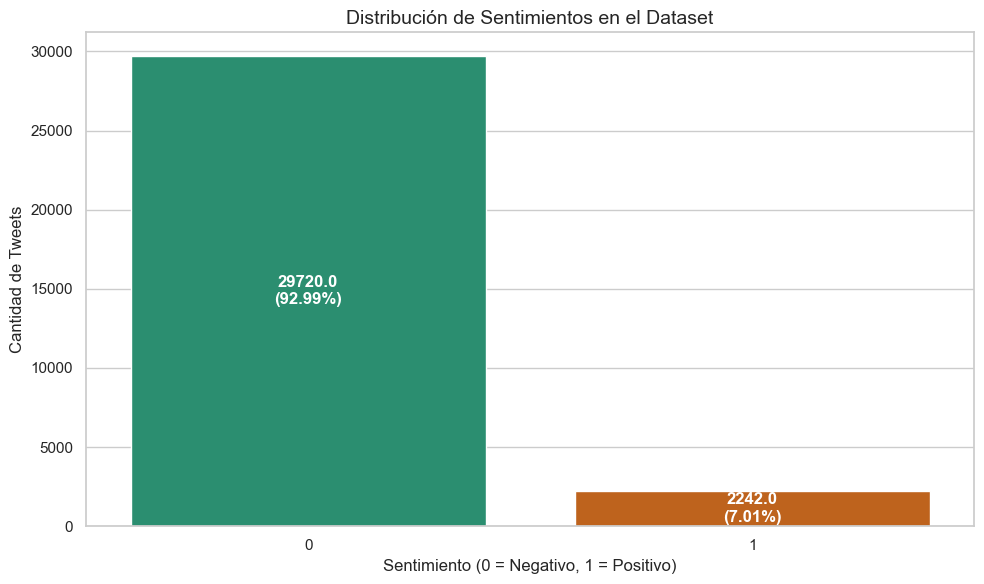

In [29]:
# Distribución de los sentimientos
plot_class_distribution(df, title="Distribución de Sentimientos en el Dataset")

## 4. Limpieza y Preprocesamiento del Texto

In [30]:
# Aplicar la función de limpieza al dataset
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

# Mostrar ejemplos antes y después de la limpieza
comparison_df = pd.DataFrame({
    'Original': df['tweet'].head(20),
    'Limpio': df['cleaned_tweet'].head(20)
})
comparison_df

,Original,Limpio
0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they d...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,factsguide: society now #motivation,factsguide society now motivation
5,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they leav...
6,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,the next school year is the year for exams.ð...,the next school year is the year for exams can...
8,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champions clev...
9,@user @user welcome here ! i'm it's so #gr...,welcome here im its so gr


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             31962 non-null  int64 
 1   label          31962 non-null  int64 
 2   tweet          31962 non-null  object
 3   cleaned_tweet  31962 non-null  object
dtypes: int64(2), object(2)
memory usage: 998.9+ KB


## 5. Análisis de Longitud de los Tweets

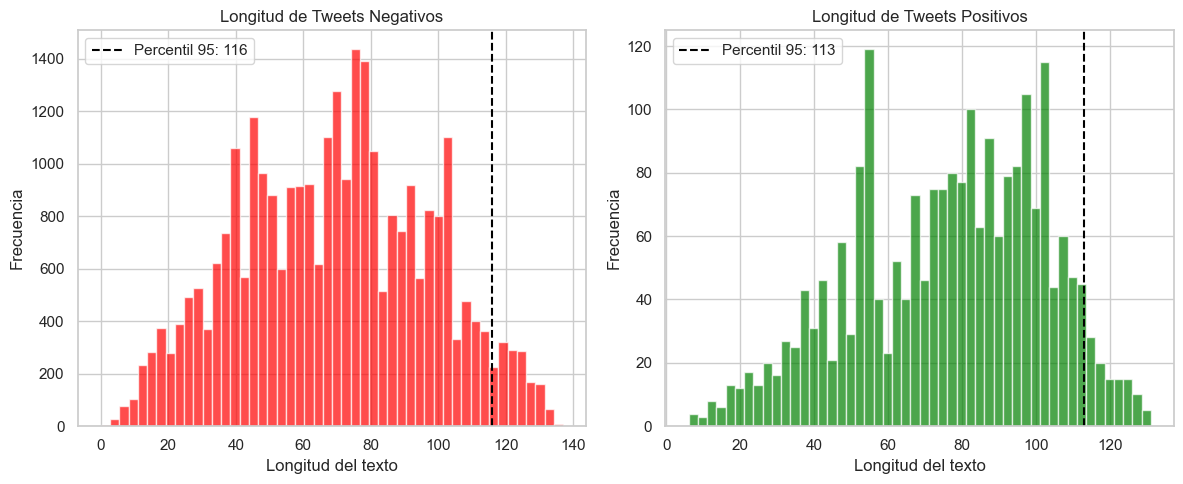

Estadísticas para tweets negativos:
count    29720.000000
mean        68.869246
std         28.025586
min          0.000000
25%         47.000000
50%         70.000000
75%         90.000000
max        137.000000
Name: text_length, dtype: float64

Estadísticas para tweets positivos:
count    2242.000000
mean       75.963426
std        25.768518
min         6.000000
25%        55.000000
50%        79.000000
75%        97.000000
max       131.000000
Name: text_length, dtype: float64


In [32]:
# Analizar la longitud de los tweets por sentimiento
plot_text_length_by_sentiment(df)

## 6. Análisis de Palabras Frecuentes

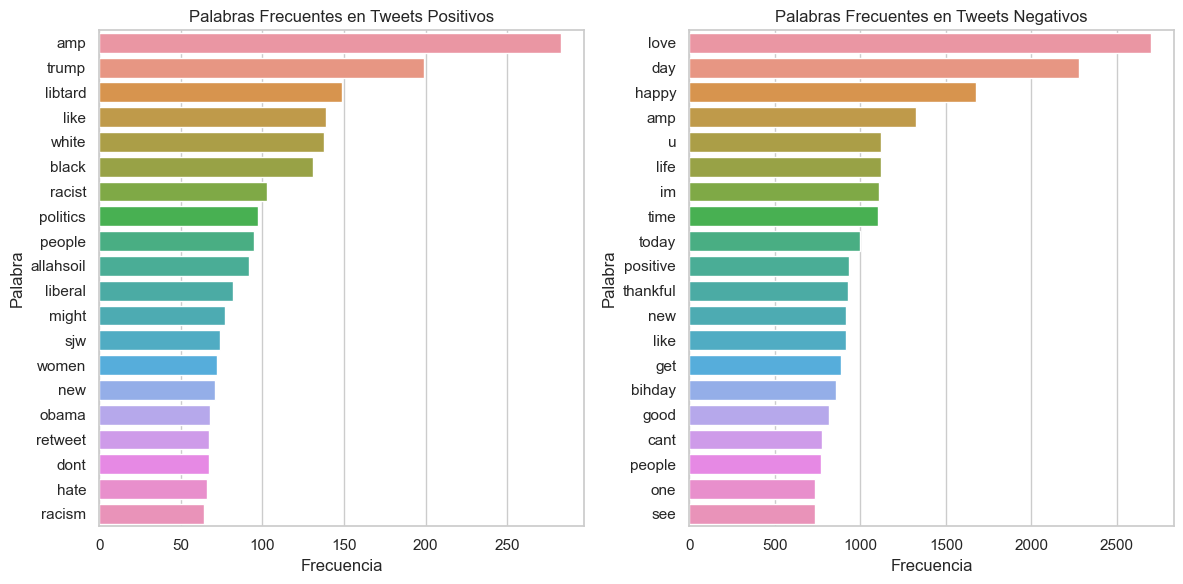

In [33]:
# Obtener stopwords en inglés
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20, stop_words=None):
    """Obtiene las n palabras más frecuentes en un conjunto de textos"""
    # Unir todos los textos y separar en palabras
    words = ' '.join(texts).split()
    
    # Filtrar stopwords si se especifican
    if stop_words is not None:
        words = [word for word in words if word not in stop_words]
    
    # Contar frecuencias
    word_counts = Counter(words)
    
    # Obtener las n palabras más frecuentes
    return word_counts.most_common(n)

# Obtener tweets positivos y negativos
positive_tweets = df[df['label'] == 1]['cleaned_tweet']
negative_tweets = df[df['label'] == 0]['cleaned_tweet']

# Obtener palabras más frecuentes
positive_words = get_top_words(positive_tweets, n=20, stop_words=stop_words)
negative_words = get_top_words(negative_tweets, n=20, stop_words=stop_words)

# Preparar datos para gráficas
pos_df = pd.DataFrame(positive_words, columns=['Palabra', 'Frecuencia'])
neg_df = pd.DataFrame(negative_words, columns=['Palabra', 'Frecuencia'])

# Visualizar palabras frecuentes en tweets positivos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Frecuencia', y='Palabra', data=pos_df)
plt.title('Palabras Frecuentes en Tweets Positivos')

# Visualizar palabras frecuentes en tweets negativos
plt.subplot(1, 2, 2)
sns.barplot(x='Frecuencia', y='Palabra', data=neg_df)
plt.title('Palabras Frecuentes en Tweets Negativos')

plt.tight_layout()
plt.show()

## 7. Nubes de Palabras por Sentimiento

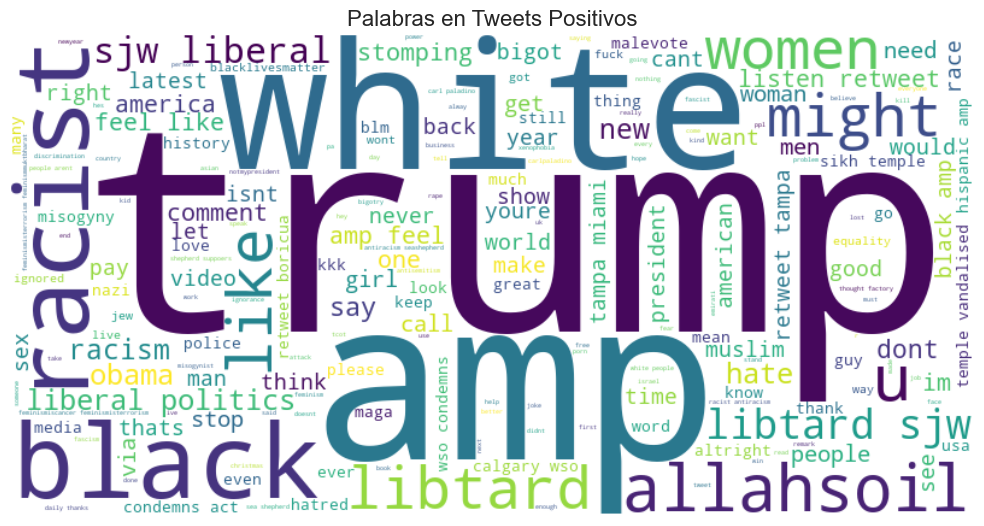

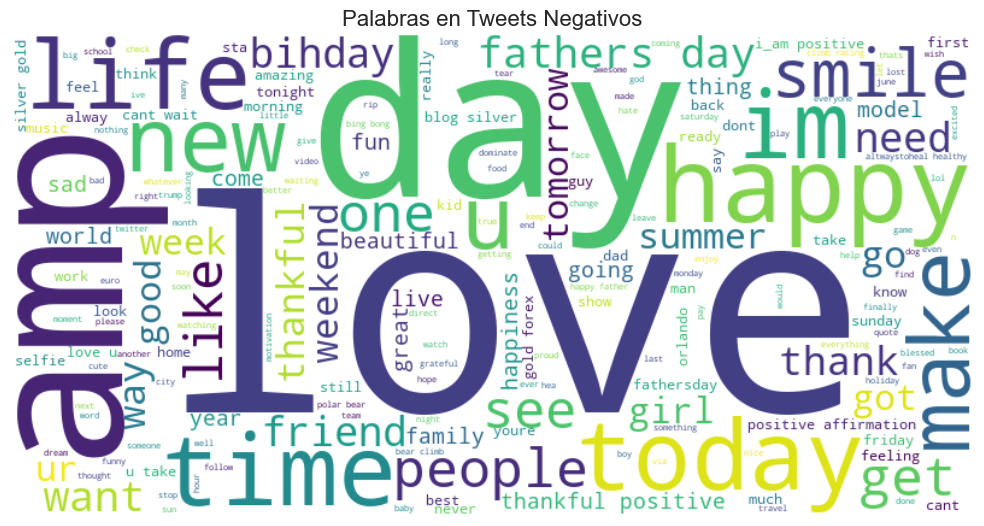

In [34]:
# Función para generar y mostrar nubes de palabras
def generate_wordcloud(texts, title=None, stopwords=None):
    # Unir todos los textos
    text = ' '.join(texts)
    
    # Crear nube de palabras
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=200,
                          stopwords=stopwords,
                          contour_width=3).generate(text)
    
    # Mostrar nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generar nubes de palabras
generate_wordcloud(positive_tweets, title='Palabras en Tweets Positivos', stopwords=stop_words)
generate_wordcloud(negative_tweets, title='Palabras en Tweets Negativos', stopwords=stop_words)

## 8. Análisis del Desbalanceo de Clases

In [35]:
# Número de ejemplos por clase
n_positive = len(df[df['label'] == 1])
n_negative = len(df[df['label'] == 0])

print(f"Tweets positivos: {n_positive}")
print(f"Tweets negativos: {n_negative}")
print(f"Ratio positivo/negativo: {n_positive/n_negative:.4f}")
print(f"Porcentaje de tweets positivos: {n_positive/(n_positive+n_negative)*100:.2f}%")
print(f"Porcentaje de tweets negativos: {n_negative/(n_positive+n_negative)*100:.2f}%")

Tweets positivos: 2242
Tweets negativos: 29720
Ratio positivo/negativo: 0.0754
Porcentaje de tweets positivos: 7.01%
Porcentaje de tweets negativos: 92.99%


## 9. Estrategias para Manejar el Desbalanceo

### 9.1 Oversampling

Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720            50.0
1            1     29720            50.0


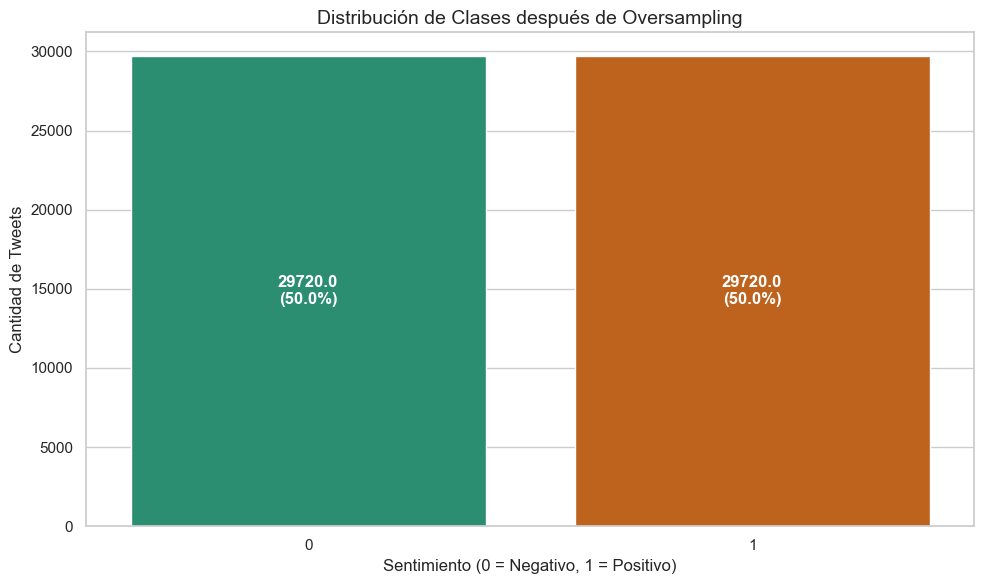

In [36]:
from sklearn.utils import resample

# Separar clases
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Duplicar clase minoritaria
df_minority_upsampled = resample(df_minority,
                               replace=True,     # muestreo con reemplazo
                               n_samples=len(df_majority),
                               random_state=42)

# Combinar
df_balanced_oversampling = pd.concat([df_majority, df_minority_upsampled])

# Barajar
df_balanced_oversampling = df_balanced_oversampling.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar la nueva distribución
plot_class_distribution(df_balanced_oversampling, title="Distribución de Clases después de Oversampling")

### 9.2 SMOTE (Synthetic Minority Over-sampling Technique)

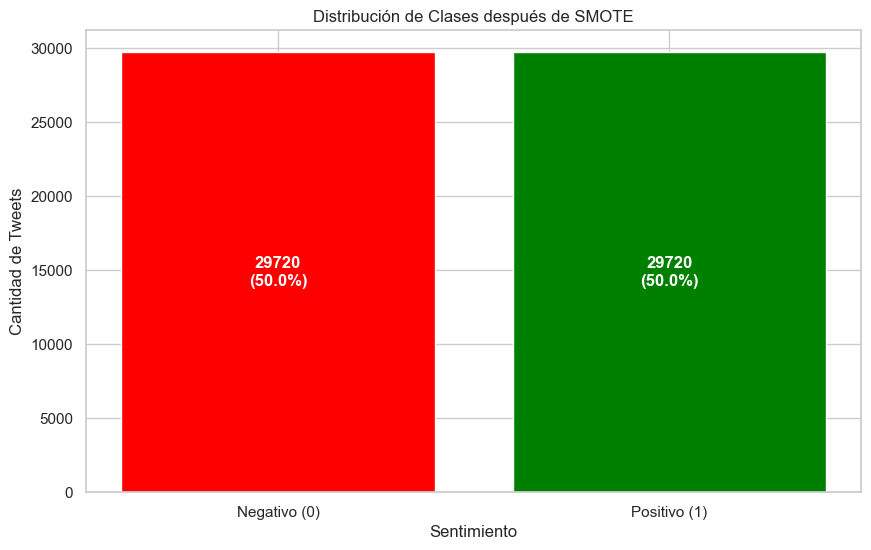

In [37]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizar textos para poder aplicar SMOTE (SMOTE necesita características numéricas)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_tweet'])
X_sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_padded = pad_sequences(X_sequences, maxlen=50)  # Padding para longitud fija
y = df['label'].values

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_padded, y)

# Verificar la nueva distribución de clases
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualizar la nueva distribución
plt.figure(figsize=(10, 6))
plt.bar(['Negativo (0)', 'Positivo (1)'], [class_distribution[0], class_distribution[1]], color=['red', 'green'])
plt.title('Distribución de Clases después de SMOTE')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')

# Añadir etiquetas con la cantidad y porcentaje
total = sum(class_distribution.values())
for i, key in enumerate(class_distribution.keys()):
    count = class_distribution[key]
    percentage = count / total * 100
    plt.text(i, count/2, f"{count}\n({percentage:.1f}%)", ha='center', va='center', fontsize=12, color='white', fontweight='bold')

plt.show()

## 10. Tokenización y Preparación para el Entrenamiento

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parámetros
max_words = 10000  # Tamaño máximo del vocabulario
max_len = 33     # Basado en longitud máxima real de los tweets tokenizados

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_tweet'], 
    df['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']  # Mantener proporción de clases
)

# Crear y ajustar el tokenizador
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para obtener secuencias de longitud uniforme
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Información sobre los datos procesados
print(f"Tamaño del vocabulario: {len(tokenizer.word_index)}")
print(f"Tamaño del conjunto de entrenamiento: {X_train_pad.shape}")
print(f"Tamaño del conjunto de prueba: {X_test_pad.shape}")

# Mostrar los primeros ejemplos de secuencias
print("\nEjemplo de secuencia:")
print(X_train_seq[0][:20], "...")

Tamaño del vocabulario: 34399
Tamaño del conjunto de entrenamiento: (25569, 33)
Tamaño del conjunto de prueba: (6393, 33)

Ejemplo de secuencia:
[246, 11, 105, 606, 26, 300, 204, 28, 368, 44, 272, 1236, 678] ...


In [22]:
def plot_token_length_by_sentiment(texts, labels):
    """
    Visualiza la distribución de la longitud de tokens por sentimiento y 
    muestra estadísticas descriptivas para ayudarte a definir el parámetro max_len.

    Args:
        texts (list or Series): Lista o Serie de textos (ya limpios).
        labels (list or Series): Lista o Serie de etiquetas (0 = negativo, 1 = positivo).
    """
    # Tokenización previa
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Calcular longitud de tokens por texto
    token_lengths = [len(seq) for seq in sequences]
    
    # Crear DataFrame temporal con etiquetas
    token_df = pd.DataFrame({
        'length': token_lengths,
        'label': labels
    })
    
    # Separar por clases
    neg_lengths = token_df[token_df['label'] == 0]['length']
    pos_lengths = token_df[token_df['label'] == 1]['length']
    
    # Gráfica
    plt.figure(figsize=(12, 5))

    # Negativos
    plt.subplot(1, 2, 1)
    plt.hist(neg_lengths, bins=50, color='red', alpha=0.7)
    p95_neg = np.percentile(neg_lengths, 95)
    plt.axvline(p95_neg, color='black', linestyle='--', label=f'Percentil 95: {p95_neg:.0f}')
    plt.title("Longitud de Tokens - Tweets Negativos")
    plt.xlabel("Cantidad de tokens")
    plt.ylabel("Frecuencia")
    plt.legend()

    # Positivos
    plt.subplot(1, 2, 2)
    plt.hist(pos_lengths, bins=50, color='green', alpha=0.7)
    p95_pos = np.percentile(pos_lengths, 95)
    plt.axvline(p95_pos, color='black', linestyle='--', label=f'Percentil 95: {p95_pos:.0f}')
    plt.title("Longitud de Tokens - Tweets Positivos")
    plt.xlabel("Cantidad de tokens")
    plt.ylabel("Frecuencia")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Estadísticas
    print("📊 Estadísticas de longitud de tokens (negativos):")
    print(neg_lengths.describe())

    print("\n📊 Estadísticas de longitud de tokens (positivos):")
    print(pos_lengths.describe())

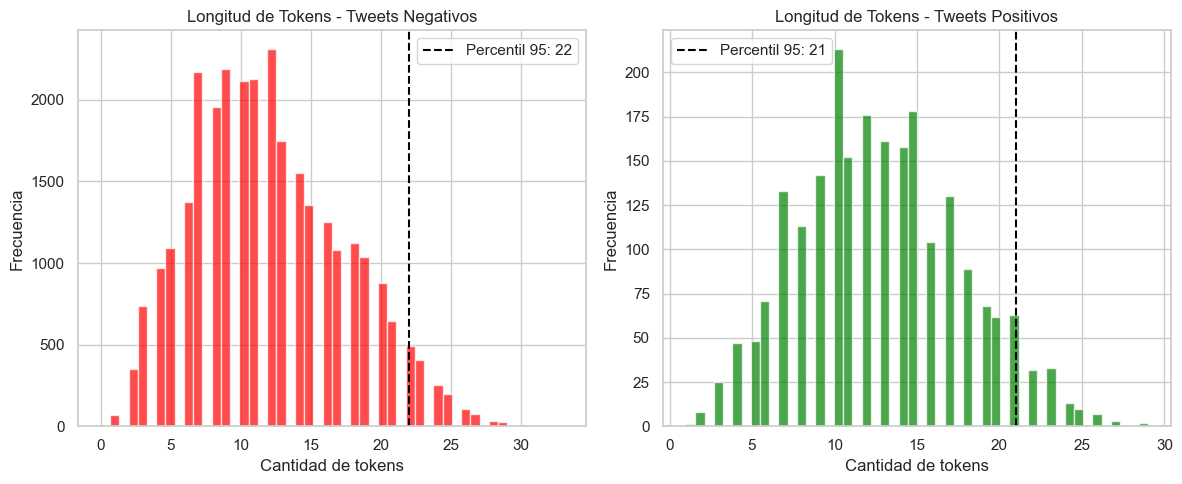

📊 Estadísticas de longitud de tokens (negativos):
count    29720.000000
mean        11.948789
std          5.419053
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         33.000000
Name: length, dtype: float64

📊 Estadísticas de longitud de tokens (positivos):
count    2242.000000
mean       12.767618
std         4.874687
min         1.000000
25%         9.000000
50%        12.000000
75%        16.000000
max        29.000000
Name: length, dtype: float64


In [23]:
plot_token_length_by_sentiment(df['cleaned_tweet'], df['label'])



## 11. Conclusiones del Análisis Exploratorio

A partir del análisis exploratorio, podemos extraer las siguientes conclusiones:

1. **Desbalanceo de clases**: El dataset muestra un fuerte desbalanceo, con aproximadamente 29,720 tweets negativos y 2,242 tweets positivos. Esto representa una proporción de 13:1 a favor de la clase negativa.

2. **Longitud de los tweets**: 
   - Para tweets negativos, el 95% tiene una longitud de 116 caracteres o menos
   - Para tweets positivos, el 95% tiene una longitud de 113 caracteres o menos
   - Esto sugiere que podemos usar una longitud máxima de 120 caracteres para nuestros modelos
   Tras analizar la longitud de los textos tokenizados, se observó que el 95% de los tweets no supera los 33 tokens. Por lo tanto, se definió max_len = 33 para aplicar padding, asegurando una representación uniforme y eficiente sin pérdida de información.

3. **Palabras frecuentes**: Existen diferencias significativas en el vocabulario utilizado entre tweets positivos y negativos, lo que sugiere que nuestros modelos podrían aprender patrones útiles para la clasificación.

4. **Estrategias para el desbalanceo**:
   - El oversampling parece una buena opción para equilibrar las clases
   - SMOTE también puede ser útil, aunque podría generar ejemplos menos representativos del lenguaje natural
   - Otra opción es utilizar class weights durante el entrenamiento

A continuación, procederemos con el entrenamiento de los diferentes modelos (RNN, LSTM, BiLSTM+Atención) y compararemos su desempeño.